### Soft sensor	development: mining	process	quality	prediction

#### -Importing necessary libraries

In [41]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### - Load the dataset and preprocess

In [42]:
# Load the dataset and preprocess
df = pd.read_csv("../dataset/MiningProcess_Flotation_Plant_Database.csv")

### - Displaying first few rows/observations of the dataset

In [43]:
# Displaying first few rows/observations of the dataset
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


### - Number of Rows and columns

In [44]:
# Rows and columns
df.shape

(737453, 24)

### - Print all the column names

In [45]:
# Print all the column names
df.columns.to_list()

['date',
 '% Iron Feed',
 '% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level',
 '% Iron Concentrate',
 '% Silica Concentrate']

### - Convert the date column to CORRECT date-times
- This will help for further processing of data
- Need to convert/process 'date' column to make/form a time series

In [46]:
# Checking the number of entries for each hour
count_df = df.groupby(['date']).count()

In [47]:
count_df.reset_index(drop=True)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174
1,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
2,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
3,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4093,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4094,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
4095,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180


In [48]:
# Find most frequent count (or samples collected) per hour
unique_counts = count_df["Starch Flow"].value_counts()

In [49]:
unique_counts

180    4095
174       1
179       1
Name: Starch Flow, dtype: int64

In [50]:
high_freq = unique_counts.idxmax()

In [51]:
high_freq

180

In [52]:
wrong_num_sample_ids = count_df.index[count_df["Starch Flow"] != high_freq]
# wrong_num_sample_ids

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])
# The real start of recording is from 00:03:00
DATA_COLLECT_START = df["date"][0].replace(minute=3)

# Fix the missing entry on 10 April 2017
row_to_repeat = df.loc[df["date"] == wrong_num_sample_ids[1]].iloc[0]
df.loc[-1] = row_to_repeat
df = df.sort_index()

# get gaps in time
t = pd.Timedelta('1hour')
mask = df['date'].diff().gt(t)
starts = df.loc[mask.shift(-1, fill_value=False), 'date'].add(t).astype(str)
stops = df.loc[mask, 'date'].sub(t).astype(str)
out = list(zip(starts, stops))

# Get list of start-end periods fo data collection
starts_ends = [str(DATA_COLLECT_START),
       str(datetime.datetime.strptime(out[0][0], '%Y-%m-%d %H:%M:%S')
           - datetime.timedelta(hours=1)),
       str(datetime.datetime.strptime(out[0][1], '%Y-%m-%d %H:%M:%S')
           - datetime.timedelta(seconds=20)),
       str(df["date"][df["date"].idxmax()] + datetime.timedelta(hours=1))]

# Get correct datetimes for dataset based on sampling rate
dates = pd.date_range(start=starts_ends[0], end=starts_ends[1], freq='20S')
dates = dates.union(pd.date_range(start=starts_ends[2], end=starts_ends[3], freq='20S'))
dates

DatetimeIndex(['2017-03-10 01:03:00', '2017-03-10 01:03:20',
               '2017-03-10 01:03:40', '2017-03-10 01:04:00',
               '2017-03-10 01:04:20', '2017-03-10 01:04:40',
               '2017-03-10 01:05:00', '2017-03-10 01:05:20',
               '2017-03-10 01:05:40', '2017-03-10 01:06:00',
               ...
               '2017-09-09 23:57:00', '2017-09-09 23:57:20',
               '2017-09-09 23:57:40', '2017-09-09 23:58:00',
               '2017-09-09 23:58:20', '2017-09-09 23:58:40',
               '2017-09-09 23:59:00', '2017-09-09 23:59:20',
               '2017-09-09 23:59:40', '2017-09-10 00:00:00'],
              dtype='datetime64[ns]', length=737454, freq=None)

### - Replace date column with correct date-times and set variable as index

In [53]:
df["date"] = dates
df.set_index('date', inplace=True)

# Check convertion
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,"56,39","13,53","2082,27","391,733","403,738","9,70067","1,74925","250,509","251,163","250,61",...,"249,43","606,023","596,422","604,776","437,7","430,352","433,92","443,036","65,85","1,4"
2017-03-10 01:03:20,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
2017-03-10 01:03:40,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2017-03-10 01:04:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
2017-03-10 01:04:20,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"


### - Convert columns/variables to numeric

In [54]:
# Convert columns/variables to numeric
# Replace ',' by '.'
for col in df.columns:
    df[col] = df[col].str.replace(',', '.').astype(float)

In [55]:
# Check convertion
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,65.85,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31


### - Checking datatypes of all columns

In [56]:
# Checking datatypes of all columns
df.dtypes

% Iron Feed                     float64
% Silica Feed                   float64
Starch Flow                     float64
Amina Flow                      float64
Ore Pulp Flow                   float64
Ore Pulp pH                     float64
Ore Pulp Density                float64
Flotation Column 01 Air Flow    float64
Flotation Column 02 Air Flow    float64
Flotation Column 03 Air Flow    float64
Flotation Column 04 Air Flow    float64
Flotation Column 05 Air Flow    float64
Flotation Column 06 Air Flow    float64
Flotation Column 07 Air Flow    float64
Flotation Column 01 Level       float64
Flotation Column 02 Level       float64
Flotation Column 03 Level       float64
Flotation Column 04 Level       float64
Flotation Column 05 Level       float64
Flotation Column 06 Level       float64
Flotation Column 07 Level       float64
% Iron Concentrate              float64
% Silica Concentrate            float64
dtype: object

### - Missing/null value checking

In [57]:
# Missing/null value checking
# All variables converted to numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737454 entries, 2017-03-10 01:03:00 to 2017-09-10 00:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737454 non-null  float64
 1   % Silica Feed                 737454 non-null  float64
 2   Starch Flow                   737454 non-null  float64
 3   Amina Flow                    737454 non-null  float64
 4   Ore Pulp Flow                 737454 non-null  float64
 5   Ore Pulp pH                   737454 non-null  float64
 6   Ore Pulp Density              737454 non-null  float64
 7   Flotation Column 01 Air Flow  737454 non-null  float64
 8   Flotation Column 02 Air Flow  737454 non-null  float64
 9   Flotation Column 03 Air Flow  737454 non-null  float64
 10  Flotation Column 04 Air Flow  737454 non-null  float64
 11  Flotation Column 05 Air Flow  737454 non-null  float64
 12  Flotation 

### - Cross-checking if there is any null values

In [58]:
# Cross-checking if there is any null values
df.isnull().sum()

% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

### - Checking additional statistics- (e.g. count, mean, std, 25%, 50%,75%, min, max)

In [59]:
# Checking additional statistics- (e.g. count, mean, std, 25%, 50%,75%, min, max)
df.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,...,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000,737454.000000
mean,56.294739,14.651714,2869.139502,488.144566,397.578380,9.767639,1.680380,280.151816,277.159930,281.082356,...,290.754800,520.244939,522.649655,531.352762,420.320997,425.251713,429.941023,421.021260,65.050069,2.326762
std,5.157741,6.807434,1215.203256,91.230541,9.699781,0.387007,0.069249,29.621288,30.149351,28.558271,...,28.670126,131.014873,128.164992,150.842086,91.794372,84.535765,89.862164,84.891437,1.118644,1.125553
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,...,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.795250,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,...,256.301250,416.978000,441.883250,411.325250,356.679250,357.653250,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.392789,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,...,299.011000,491.878000,495.956000,494.318000,411.974500,408.773500,424.664787,411.065500,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.256750,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,...,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,...,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


#### - Visualization (Box-Plot of all variables)

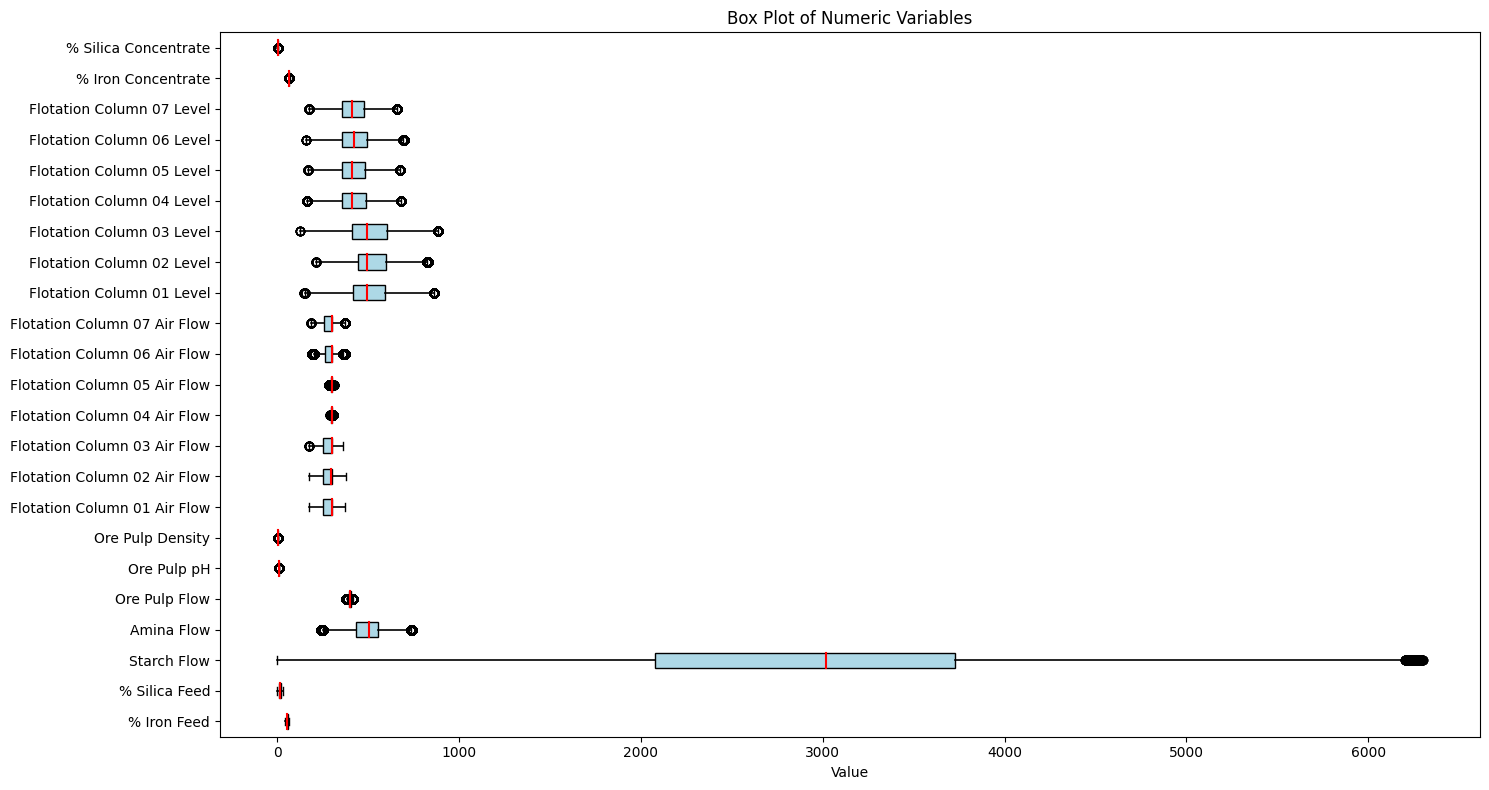

In [60]:
# Select numeric variables
numeric_variables = df.select_dtypes(include='number')

fig, ax = plt.subplots(figsize=(15, 8))

# Create a box plot for each numeric variable
box_plot = ax.boxplot(numeric_variables.values, vert=False, patch_artist=True)

for box in box_plot['boxes']:
    box.set(facecolor='lightblue')
for whisker in box_plot['whiskers']:
    whisker.set(color='black', linestyle='-', linewidth=1.2)
for median in box_plot['medians']:
    median.set(color='red', linewidth=1.5)

ax.set_yticklabels(numeric_variables.columns)

ax.set_xlabel('Value')
ax.set_title('Box Plot of Numeric Variables')

# Show the plot
plt.tight_layout()
plt.show()

#### - Visualization (individual Box-Plot of all variables)

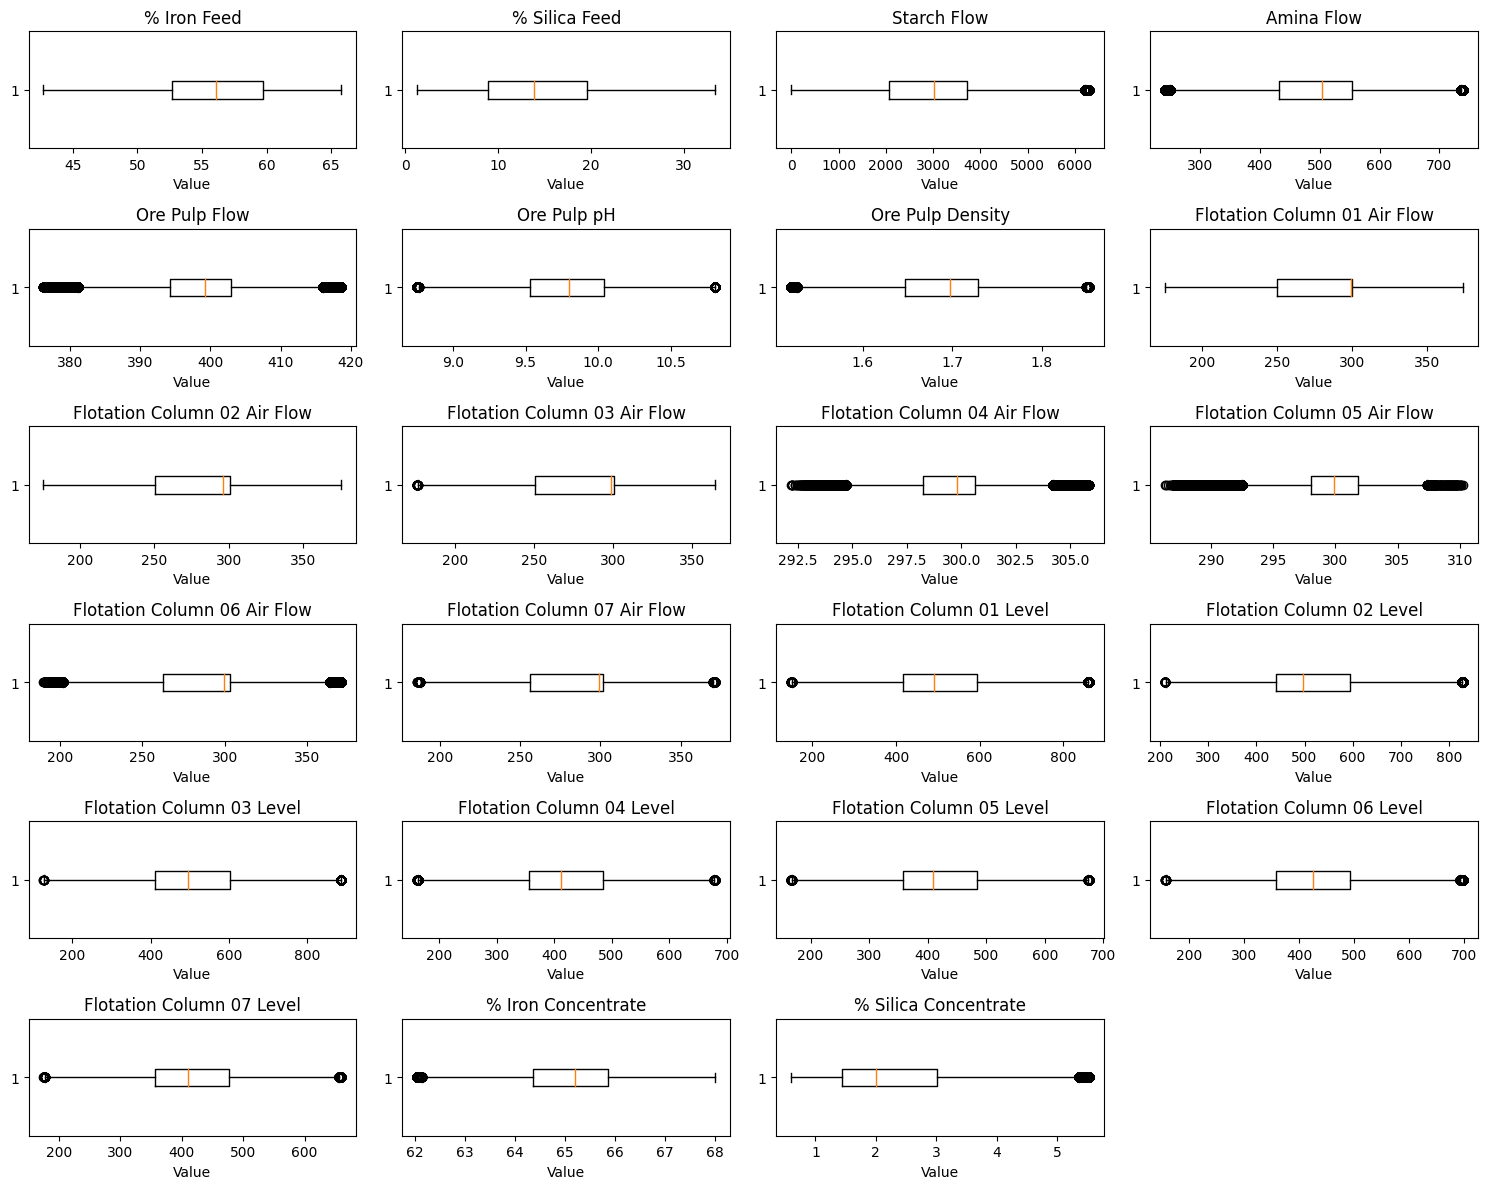

In [61]:
numeric_variables = df.select_dtypes(include='number')

column_names = numeric_variables.columns

# Subplots per row for better visualization
num_cols = 4
num_rows = len(column_names) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

if num_rows == 1:
    axes = axes.reshape(1, -1)

# Create box plots for each numeric variable
for i, column in enumerate(column_names):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]

    ax.boxplot(df[column], vert=False)
    ax.set_title(column)
    ax.set_xlabel('Value')

for i in range(len(column_names), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### - Visualization (Histogram of all variables)

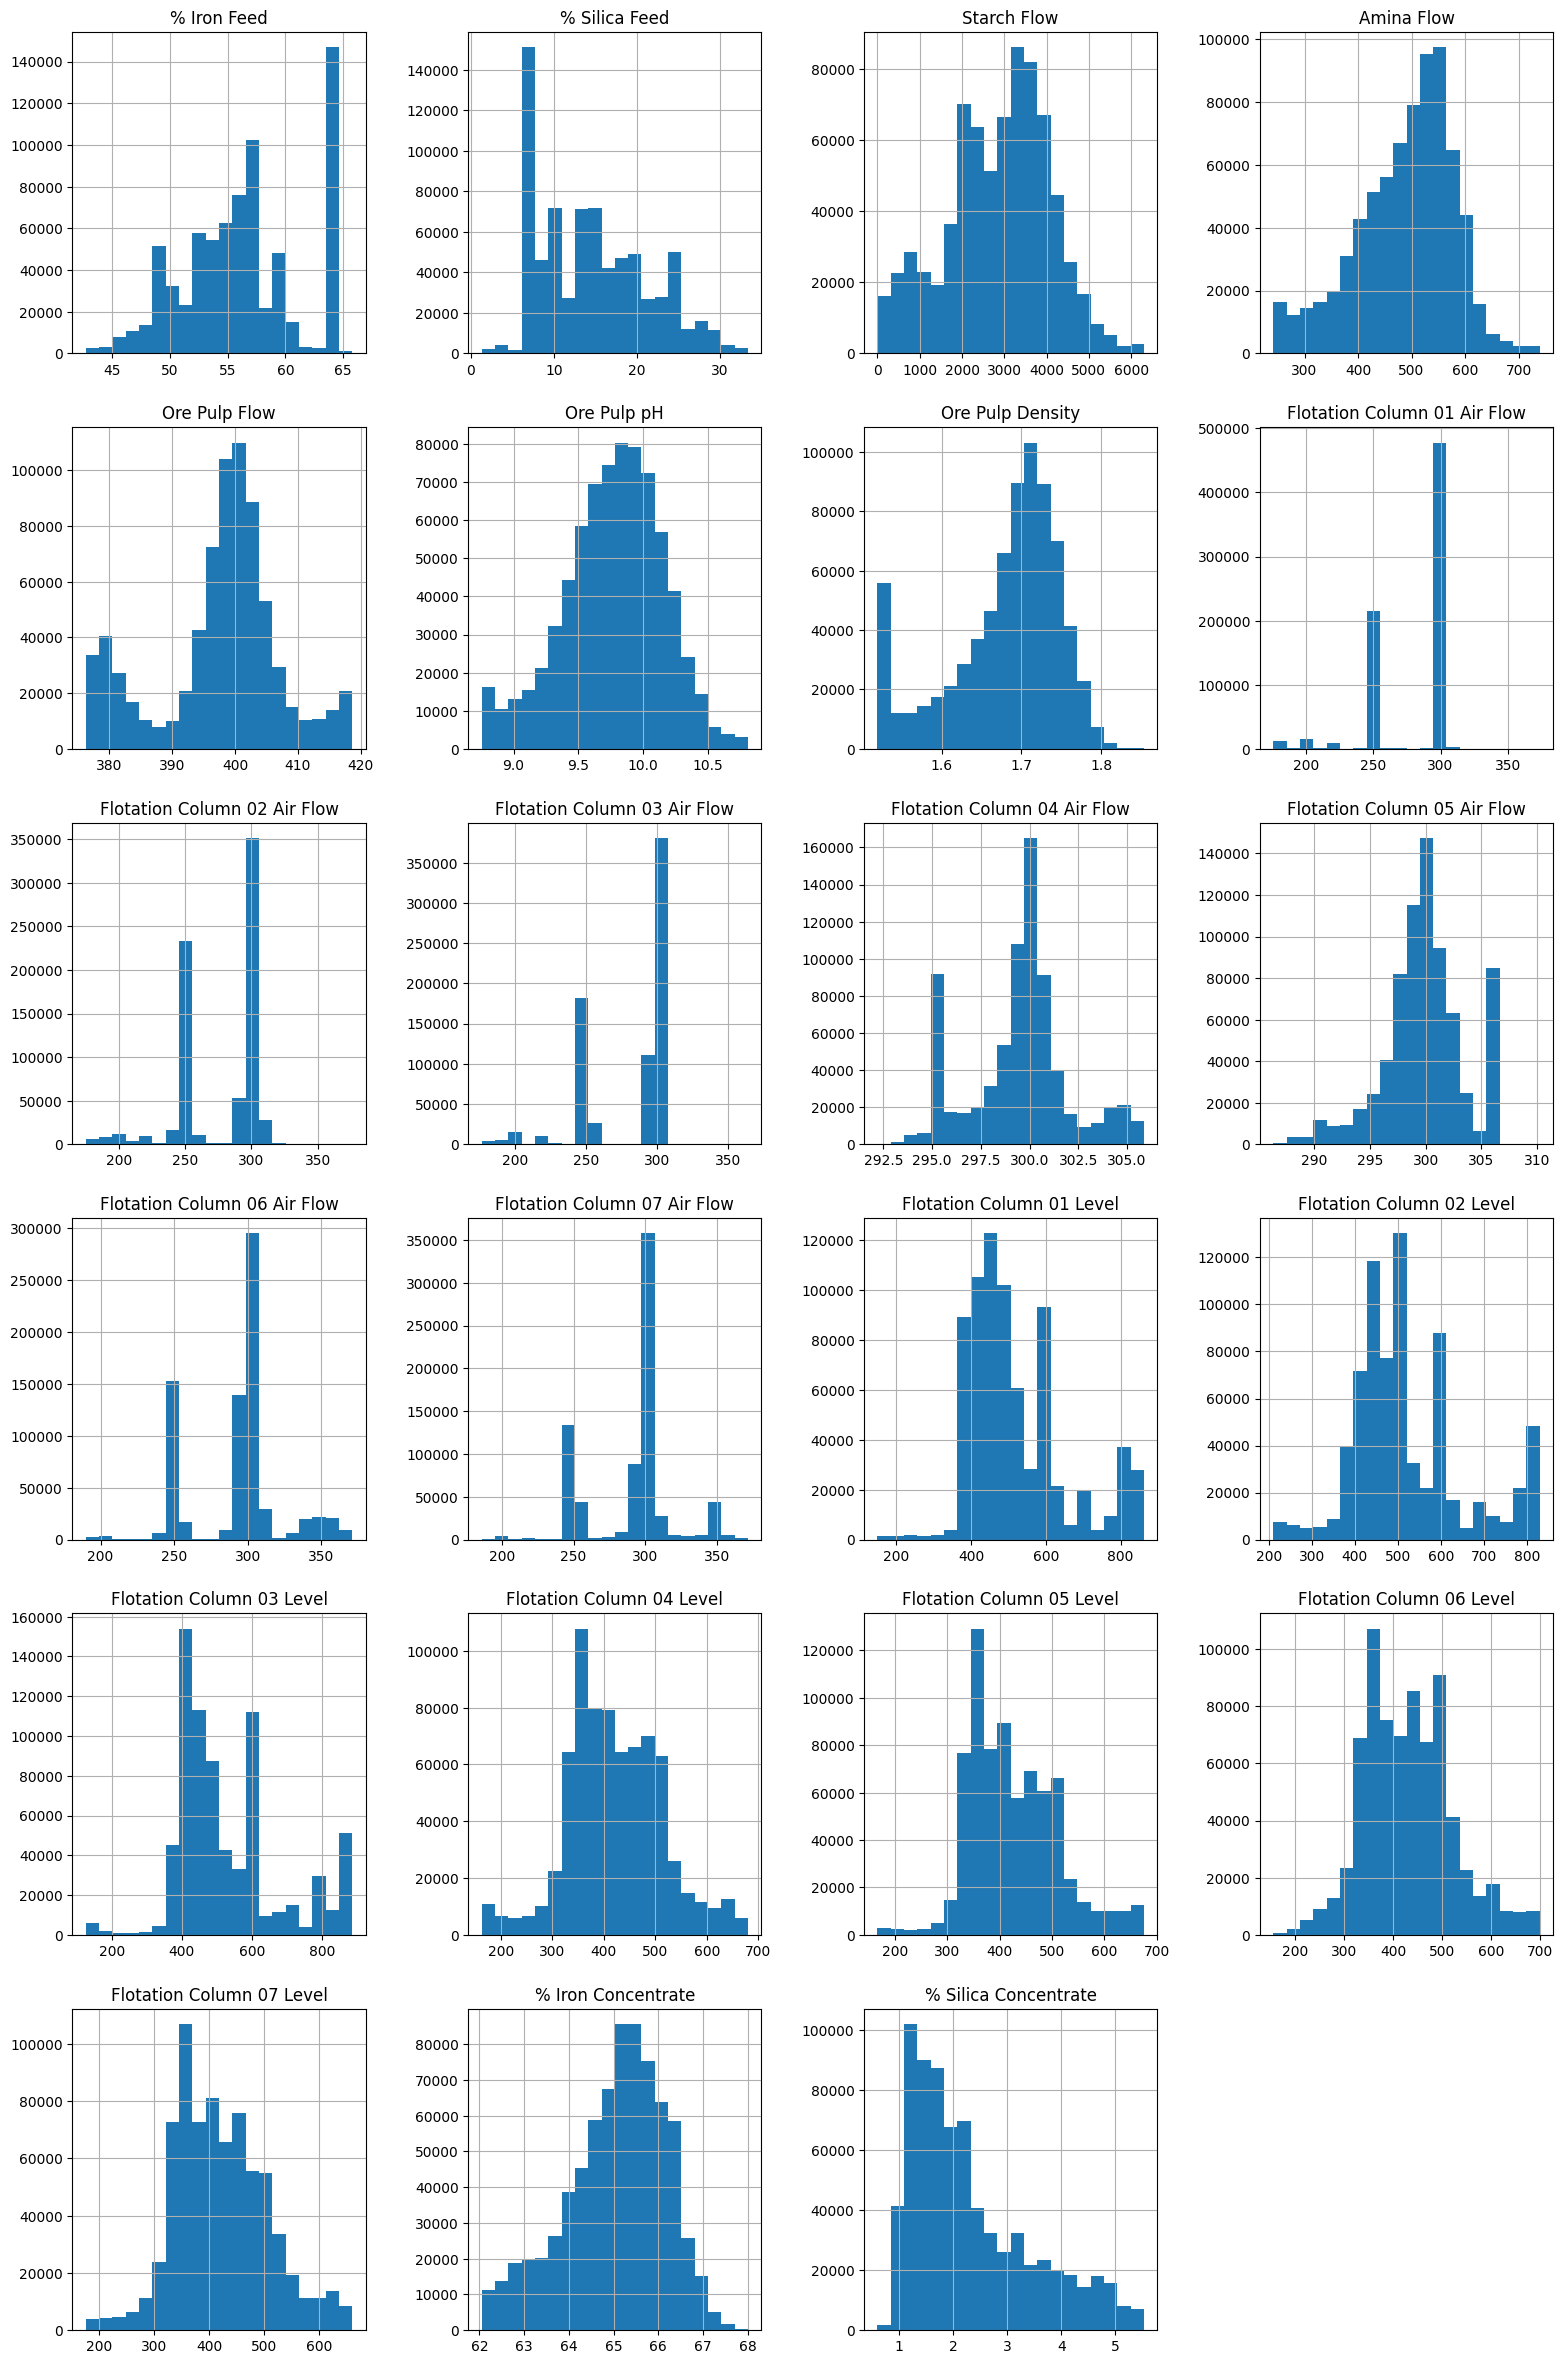

In [62]:
# Get numeric variables
numeric_variables = df.select_dtypes(include='number')

# Subplots per row for better visualization
subplots_per_row = 4
num_variables = len(numeric_variables.columns)
num_rows = (num_variables + subplots_per_row - 1) // subplots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(16, 4 * num_rows), sharex=False)

axes = axes.flatten()

# Plot histograms for each numeric variable
for i, col in enumerate(numeric_variables.columns):
    ax = axes[i]
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    ax.grid(True)

for i in range(num_variables, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()

### - Visualization (Correlation matrix)
- Find the relationships among variables, specially when there are huge number of observations
-  Helpful for understanding redundant variables

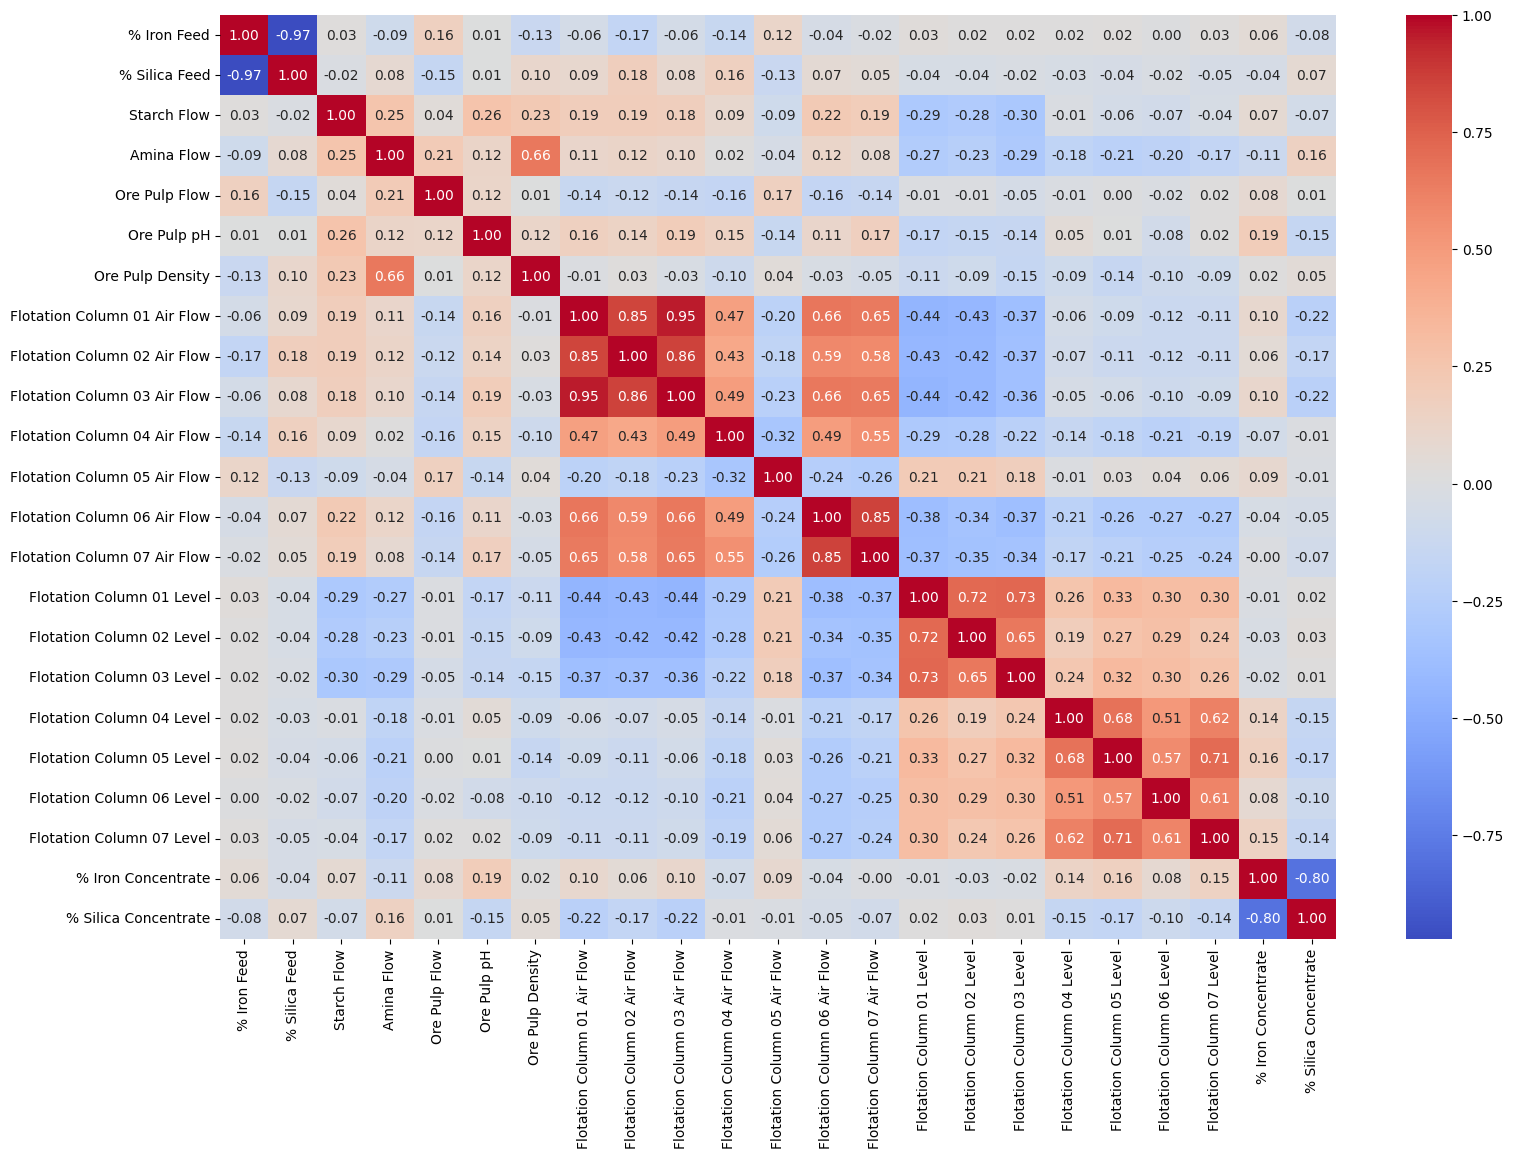

In [63]:
# Select numeric variables (excluding any non-numeric columns)
#numeric_variables = df.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### - Plot against time
- Plot the time series for all variables in one figure

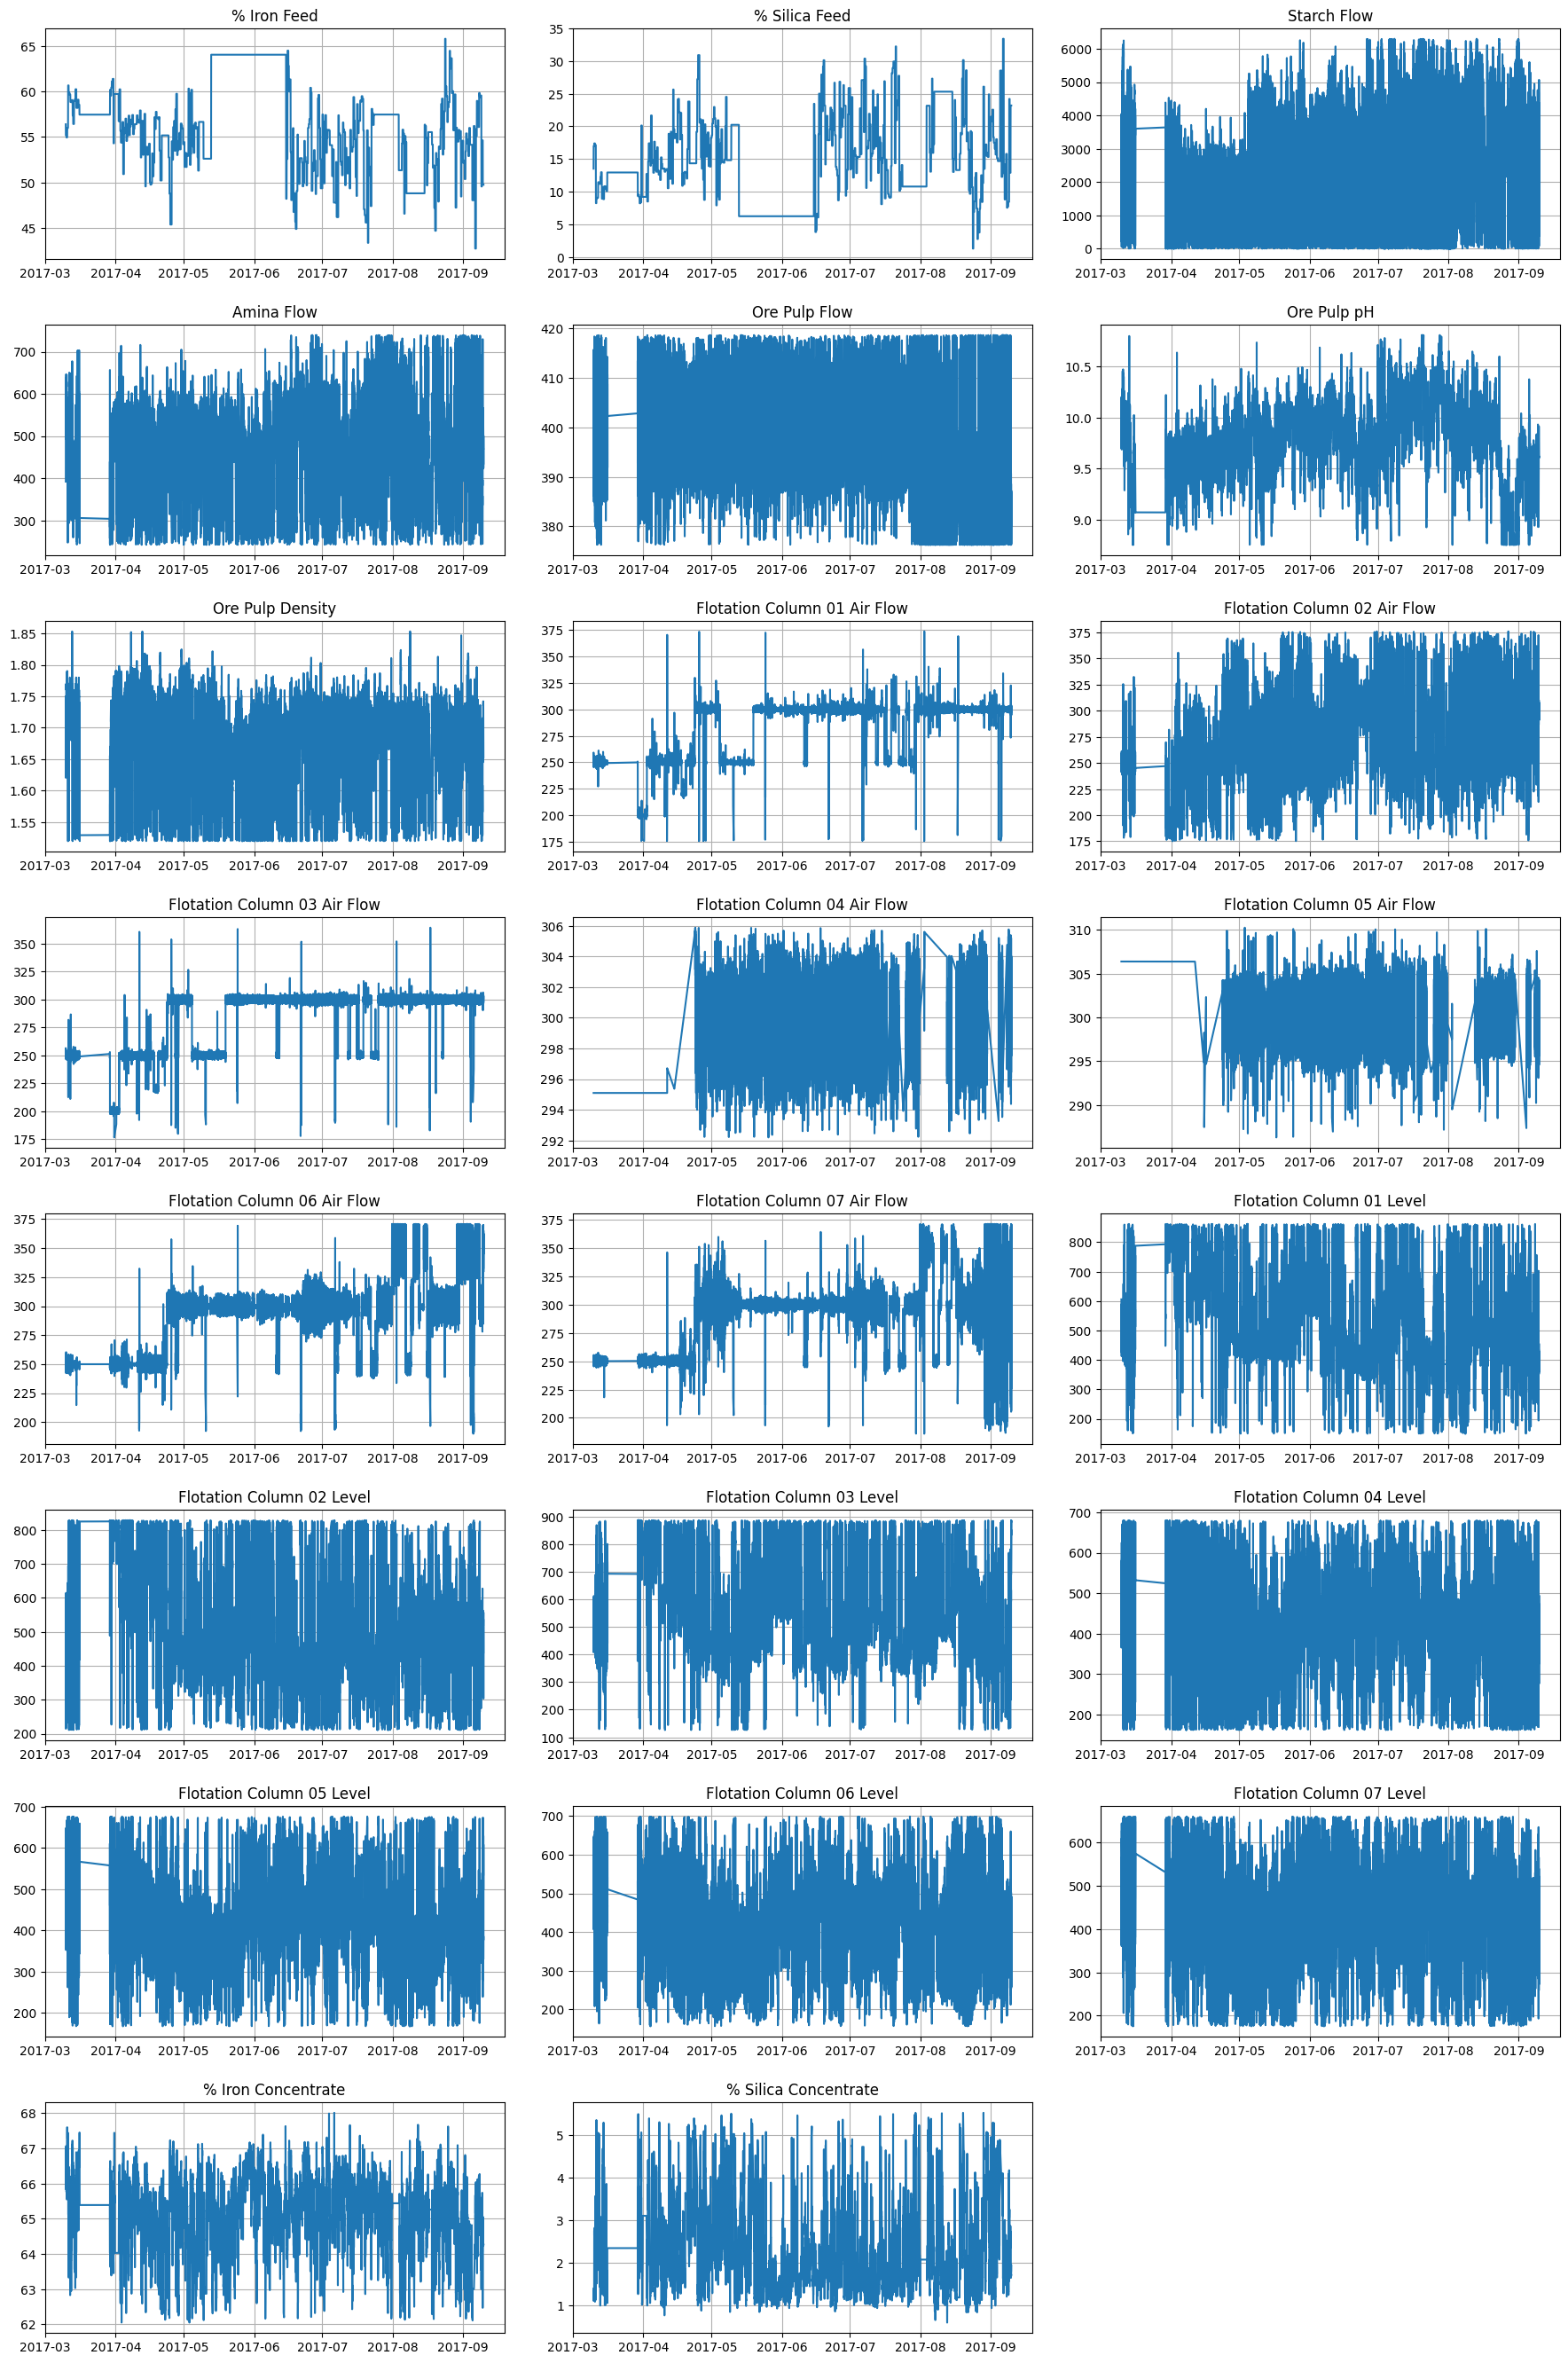

In [64]:
# Get numeric variables
numeric_variables = df.select_dtypes(include='number')

# Subplots per row for better visualization
subplots_per_row = 3
num_variables = len(numeric_variables.columns)
num_rows = (num_variables + subplots_per_row - 1) // subplots_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(18, 27), sharex=False)

axes = axes.flatten()

# Plot time series for each numeric variable
for i, col in enumerate(numeric_variables.columns):
    ax = axes[i]
    ax.plot(df.index, df[col])
    ax.set_title(col)
    ax.grid(True)

for i in range(num_variables, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout(pad=2.0)
plt.show()

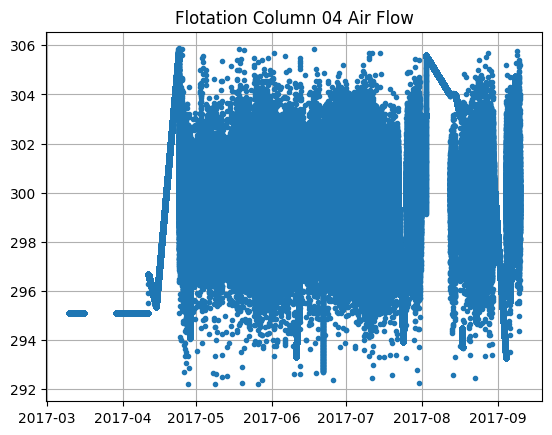

In [65]:
# Plot the time series for just one variable
# Using just marker shows better where values stay the same
column_name = 'Flotation Column 04 Air Flow'
plt.plot(df.index, df[column_name], '.')
plt.title(column_name)
plt.grid(True)
plt.show()

### Need to provde description:
- Do we need resample or preprocess the data to make it synchronize? If yes then what is the plan?
- Is there are any irrelevant or redundant variables that don't contribute to the analysis or prediction.
- Identification of pretreatment steps, and a plan on how to do data pretreatment
- Identify which variables are time series data and which are not. Time series data will have timestamps associated with them.
- I dentify different measurement unit or scale of the variables
- How do we deal with the different measurements/scale

### Identification of Pretreatment Steps:

- Handling Missing Values: If missing values are detected, decide on a strategy to handle them. Options include imputation (e.g., mean, median, forward-fill, or interpolation) or removal of rows/columns with missing values.
- Resampling: If time series data is not synchronized, we may need to resample it to a consistent time interval.
- Feature Selection: Assess the relevance of each variable for our analysis or modeling task. Remove any irrelevant or redundant variables.
- Data Scaling/Normalization: Depending on the modeling techniques that we plan to use, may need to scale or normalize the data to ensure all variables have similar ranges.
- Outlier Detection and Handling: Identify and handle outliers if they exist in the dataset. Outliers can significantly impact modeling results.
- Data Splitting: FOr our predictive models, need to decide how to split the data into training, validation, and test sets.


## Data centering and scaling techniques

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

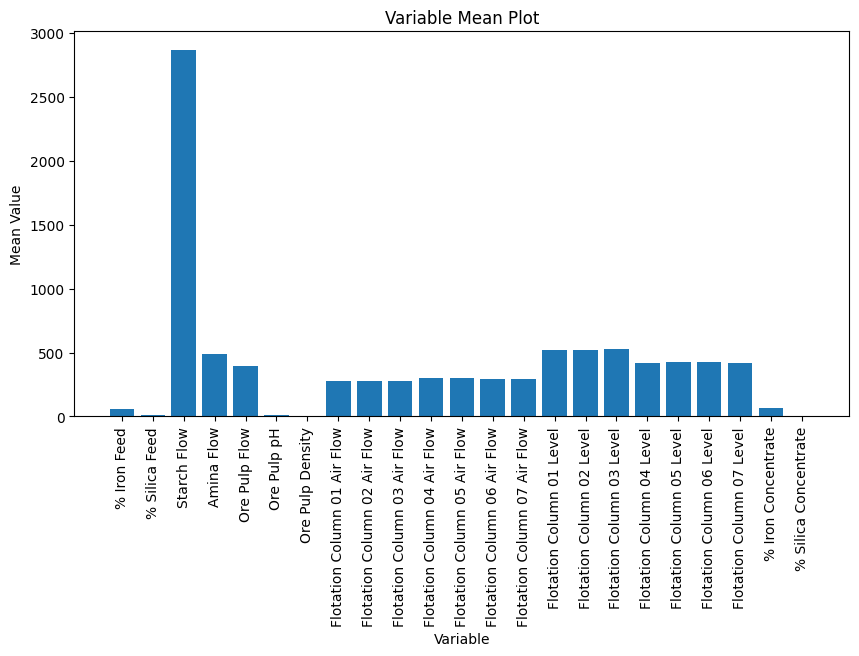

In [67]:
# Select the relevant columns (exclude non-numeric columns if any)
numeric_data = df.select_dtypes(include=[np.number])

# (a) Variable Mean Plot
variable_means = numeric_data.mean()
plt.figure(figsize=(10, 5))
plt.bar(variable_means.index, variable_means)
plt.xticks(rotation=90)
plt.title('Variable Mean Plot')
plt.xlabel('Variable')
plt.ylabel('Mean Value')
plt.show()

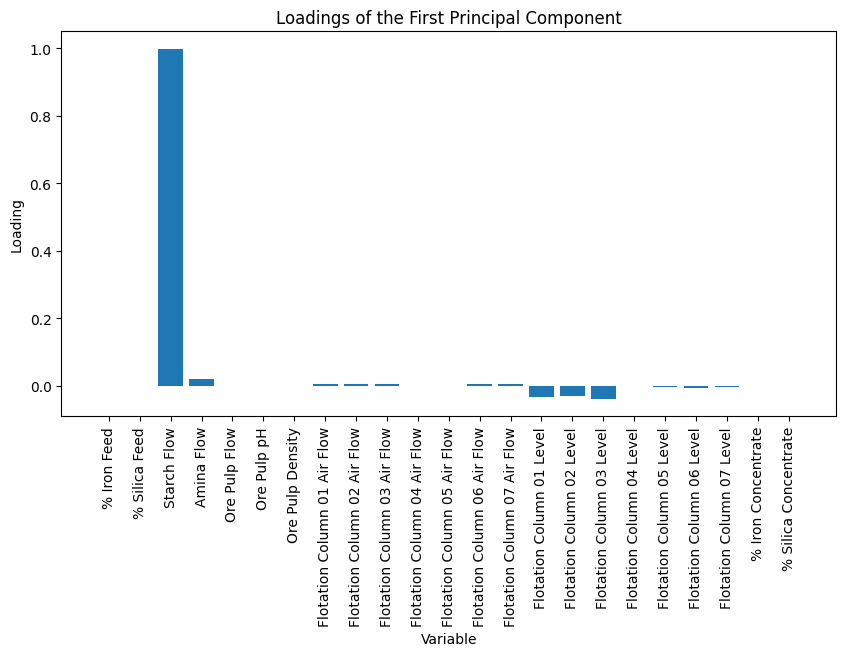

In [68]:
# (b) First Component Loading of the Non-Pretreated Data
pca = PCA(n_components=1)
component_1 = pca.fit_transform(numeric_data)
loading_1 = pca.components_[0]
plt.figure(figsize=(10, 5))
plt.bar(numeric_data.columns, loading_1)
plt.xticks(rotation=90)
plt.title('Loadings of the First Principal Component')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()

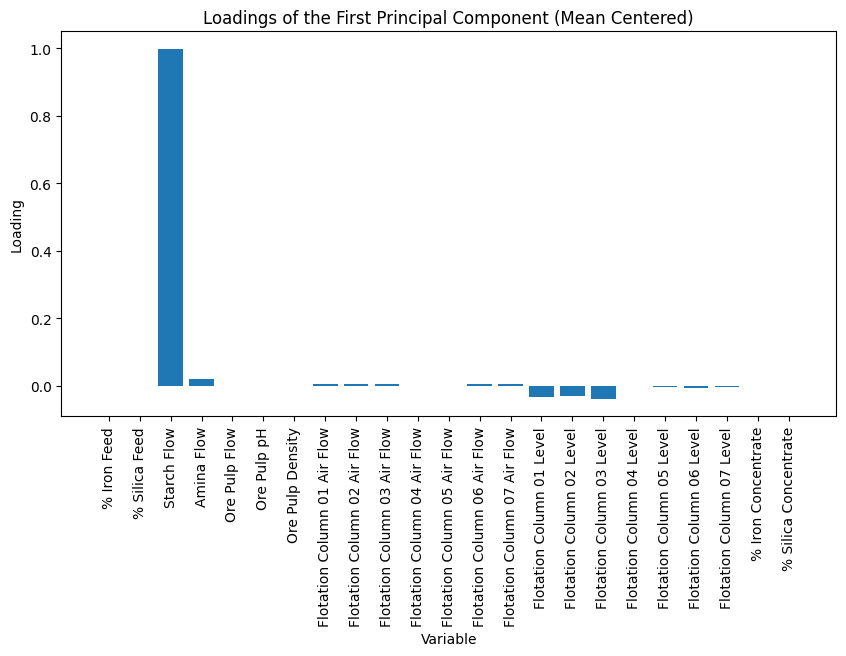

In [69]:
# (c) Loadings of the First PC when Data is Mean Centered
numeric_data_mean_centered = numeric_data - numeric_data.mean()
numeric_data_mean_centered['% Silica Concentrate'] *= 10  # Modify the last variable to dominate
pca_mean_centered = PCA(n_components=1)
component_1_mean_centered = pca_mean_centered.fit_transform(numeric_data_mean_centered)
loading_1_mean_centered = pca_mean_centered.components_[0]
plt.figure(figsize=(10, 5))
plt.bar(numeric_data.columns, loading_1_mean_centered)
plt.xticks(rotation=90)
plt.title('Loadings of the First Principal Component (Mean Centered)')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()

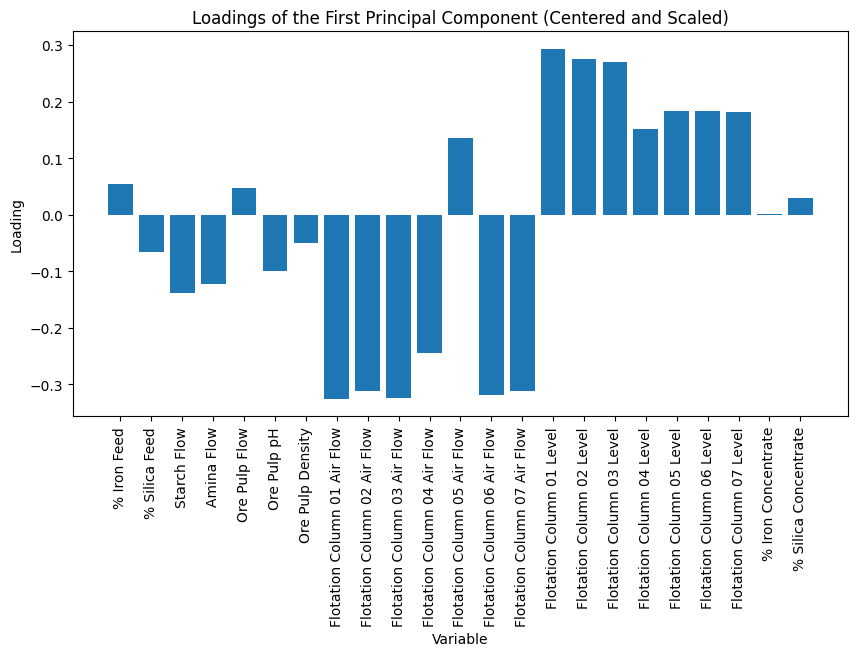

In [70]:
# (d) Loadings of the 1st PC when Variables are Centered and Scaled
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)
pca_scaled = PCA(n_components=1)
component_1_scaled = pca_scaled.fit_transform(numeric_data_scaled)
loading_1_scaled = pca_scaled.components_[0]
plt.figure(figsize=(10, 5))
plt.bar(numeric_data.columns, loading_1_scaled)
plt.xticks(rotation=90)
plt.title('Loadings of the First Principal Component (Centered and Scaled)')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()

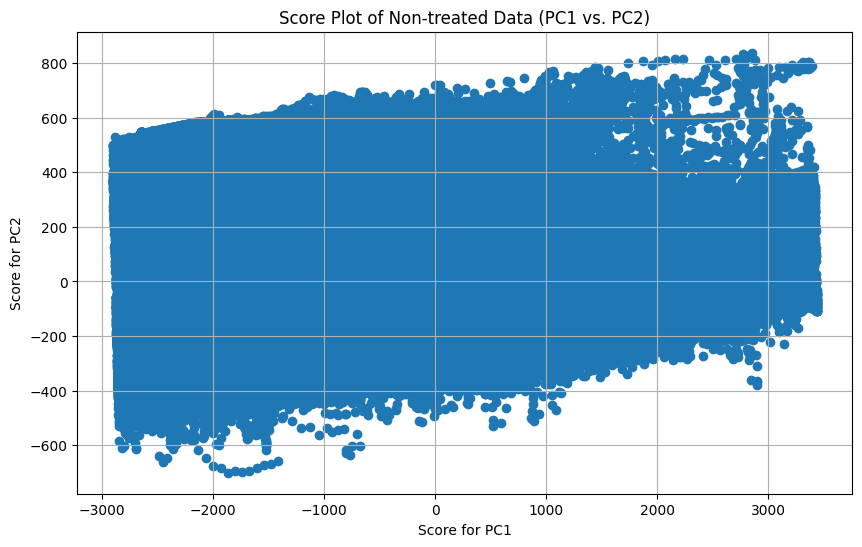

In [71]:
# Select the relevant columns
numeric_data = df.select_dtypes(include=[np.number])

# Perform PCA without any pretreatment
pca = PCA(n_components=2)  # Specify 2 components for PC1 and PC2
components = pca.fit_transform(numeric_data)

# Create a scatter plot of the scores for PC1 and PC2
plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1])
plt.title('Score Plot of Non-treated Data (PC1 vs. PC2)')
plt.xlabel('Score for PC1')
plt.ylabel('Score for PC2')
plt.grid(True)
plt.show()

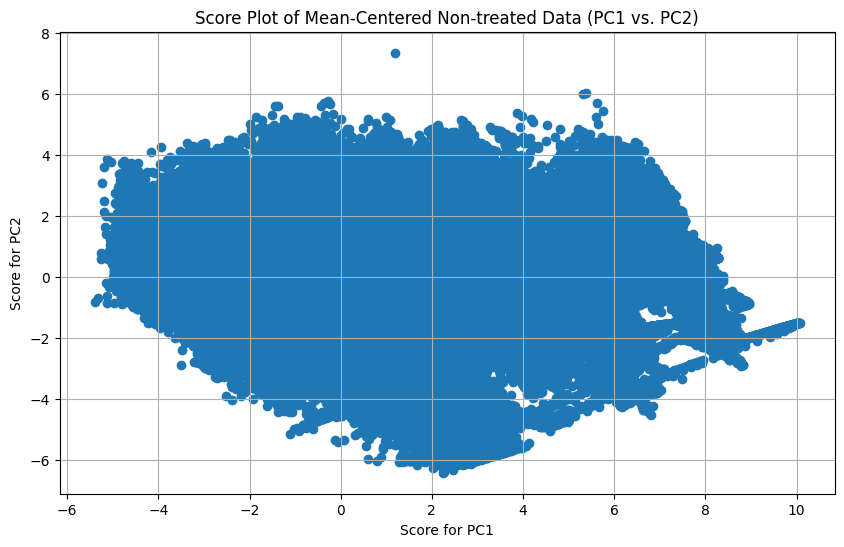

In [72]:
# Mean center the data
scaler = StandardScaler()
mean_centered_data = scaler.fit_transform(numeric_data)

# Perform PCA on the mean-centered data
pca = PCA(n_components=2)  # Specify 2 components for PC1 and PC2
components = pca.fit_transform(mean_centered_data)

# Create a scatter plot of the scores for PC1 and PC2
plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1])
plt.title('Score Plot of Mean-Centered Non-treated Data (PC1 vs. PC2)')
plt.xlabel('Score for PC1')
plt.ylabel('Score for PC2')
plt.grid(True)
plt.show()

- From the above figure we can see that PC1 comprises almost equally, positively and negatively associated patterns
- There are some outlicers too those are far from the densed datapints

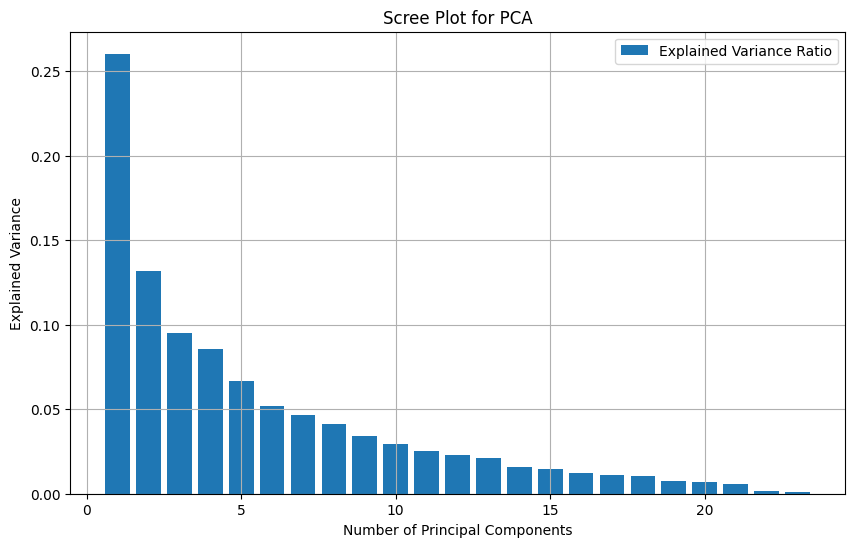

In [73]:
# For PCA, you only need the independent variables

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio for each PC
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance Ratio')
#plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='red', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot for PCA')
plt.legend()
plt.grid()
plt.show()

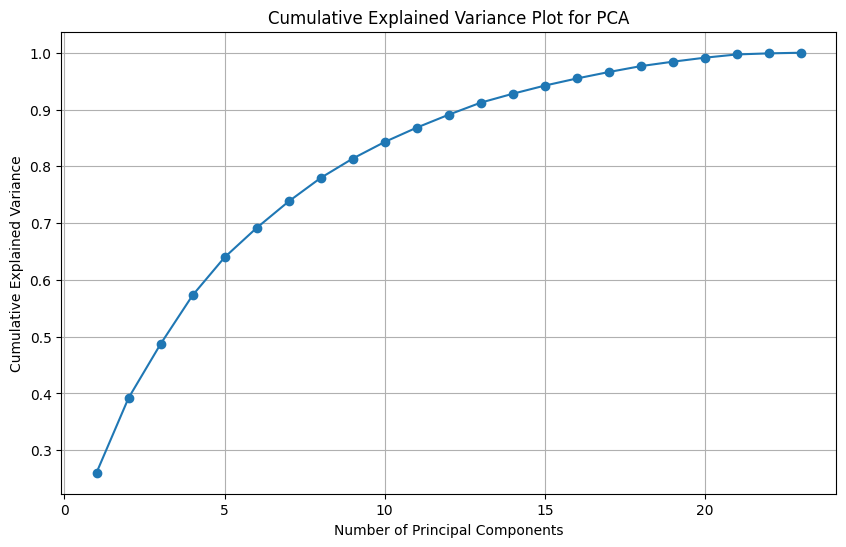

In [74]:
# Create a cumulative explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot for PCA')
plt.grid()
plt.show()

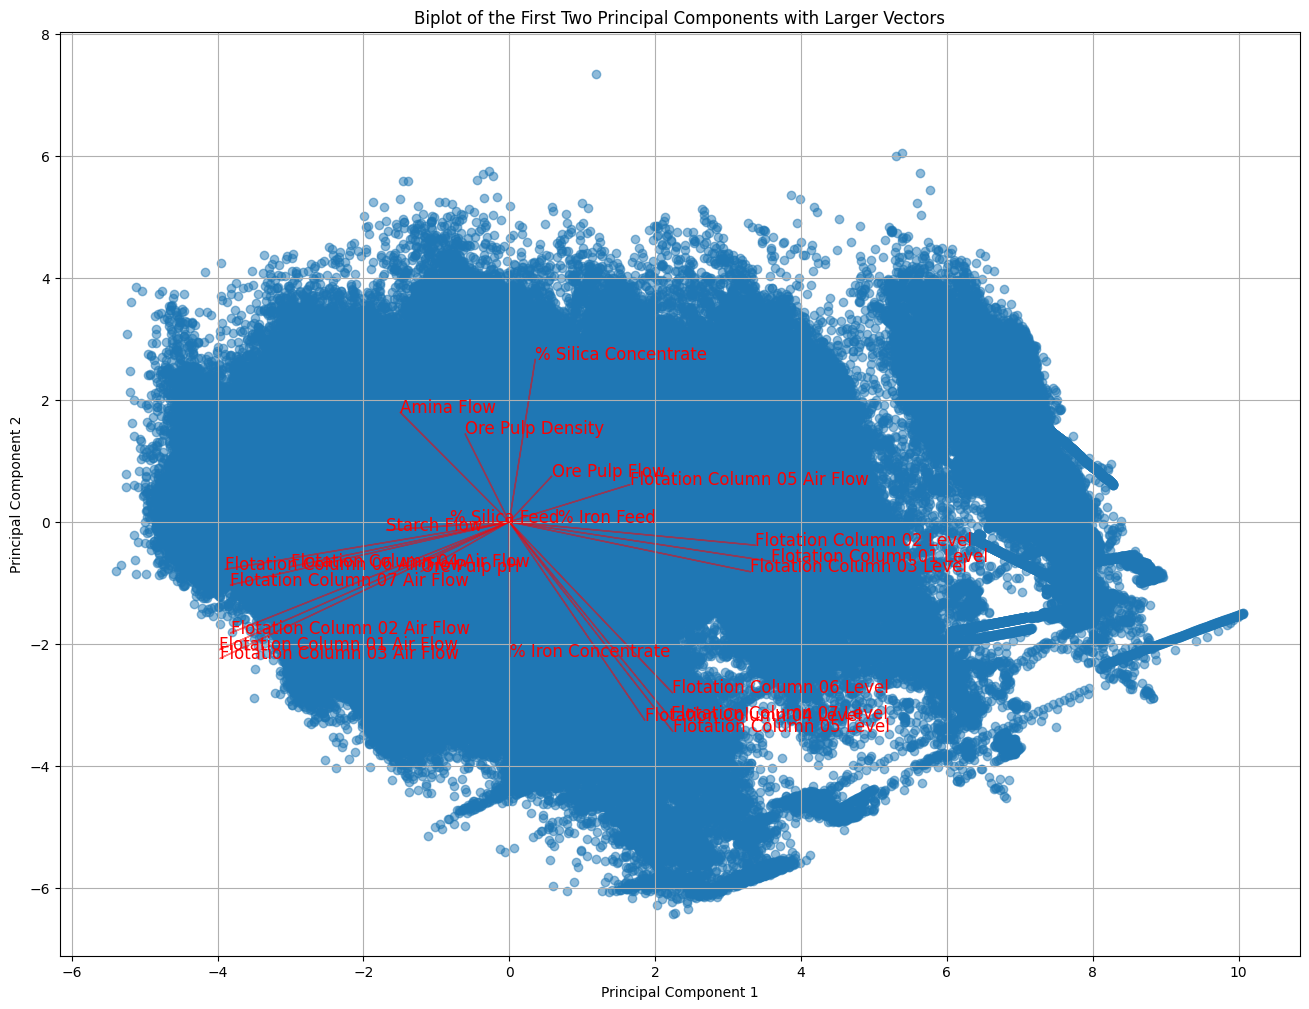

In [75]:
# Transform the original data to the first two principal components

# Assuming 'X_scaled' is your scaled and centered data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(16, 12))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)

# Define a scaling factor for the vectors (e.g., 3 times longer)
scaling_factor = 5

# Add variable loadings as vectors with adjusted scaling
for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, x * scaling_factor, y * scaling_factor, color='r', alpha=0.5)
    plt.text(x * scaling_factor, y * scaling_factor, df.columns[i], color='r', fontsize=12)

# Set axis labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot of the First Two Principal Components with Larger Vectors')

# Show the plot
plt.grid()
plt.show()

In [76]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,65.85,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31


In [77]:
df.shape

(737454, 23)

In [78]:
# Drop the iron outlet concentration
df = df.drop(columns=['% Iron Concentrate'])
df.to_csv("preprocessed_dataset.csv", sep=",")

numeric_variables = df.select_dtypes(include='number')

### Include data from the normal functioning periods only

In [79]:
from datetime import datetime
# List of intervals
intervals = [
    (datetime(2017, 4, 23, 19, 0, 0), datetime(2017, 5, 13, 0, 59, 40)),
    (datetime(2017, 6, 15, 1, 0, 0), datetime(2017, 7, 24, 0, 59, 40)),
    (datetime(2017, 8, 15, 1, 0, 0), datetime(2017, 9, 10, 0, 0, 0))
]
# We will need to skip at the end of intervals to avoid predicting from previous interval...
interval_lens = [len(df.loc[start_date:end_date]) for start_date, end_date in intervals]
interval_lens_cum_sums = np.cumsum(interval_lens)
print(interval_lens_cum_sums)

filtered_df = pd.DataFrame()

for start_date, end_date in intervals:
    interval_df = df.loc[start_date:end_date]
    filtered_df = pd.concat([filtered_df, interval_df])

[ 83160 251640 363781]


In [80]:
filtered_df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-04-23 19:00:00,55.17,14.35,1949.14,598.517,401.144,9.59717,1.74016,301.947,312.676,294.916,...,291.793,274.154,406.587,387.672,377.023,394.365,382.256,316.513,315.184,4.047127
2017-04-23 19:00:20,55.17,14.35,1956.79,602.111,402.942,9.59188,1.74021,301.300,303.034,292.731,...,289.573,271.524,405.270,399.660,382.336,396.537,381.211,383.975,351.874,4.050000
2017-04-23 19:00:40,55.17,14.35,1967.95,599.218,403.024,9.58660,1.74026,301.389,299.737,293.032,...,289.524,270.211,404.740,410.723,403.418,369.448,375.898,419.544,384.273,4.050000
2017-04-23 19:01:00,55.17,14.35,1972.66,601.801,398.425,9.58304,1.74031,302.346,310.240,293.998,...,291.359,281.027,404.416,406.286,420.258,365.552,346.427,395.045,406.537,4.050000
2017-04-23 19:01:20,55.17,14.35,1972.66,600.950,396.381,9.58118,1.74037,302.652,307.941,294.611,...,291.666,280.570,407.907,433.942,411.979,353.836,344.122,338.010,389.218,4.050000


In [81]:
filtered_df.shape

(363781, 22)

In [82]:
df=filtered_df

In [83]:
df.shape

(363781, 22)

In [84]:
df['% Silica Concentrate'].mean()

2.3245273038643357

In [85]:
df.shape

(363781, 22)

In [86]:
df['% Silica Concentrate'].mean()

2.3245273038643357

In [87]:
df['% Silica Concentrate'].max()

5.53

In [88]:
"""
df['% Silica Concentrate'].min()
df['% Silica Concentrate'].nlargest(2).iloc[-1]
df['% Silica Concentrate'].drop_duplicates().nsmallest(8).iloc[-1]
df['% Silica Concentrate'].std()
#df[df['% Silica Concentrate']>=df['% Silica Concentrate'].min()]
df[16570:16572]['% Silica Concentrate'].to_list()
"""

"\ndf['% Silica Concentrate'].min()\ndf['% Silica Concentrate'].nlargest(2).iloc[-1]\ndf['% Silica Concentrate'].drop_duplicates().nsmallest(8).iloc[-1]\ndf['% Silica Concentrate'].std()\n#df[df['% Silica Concentrate']>=df['% Silica Concentrate'].min()]\ndf[16570:16572]['% Silica Concentrate'].to_list()\n"

In [89]:
int(df.shape[0]*0.8)

291024

In [52]:
# For the development purpose take small chunk to run model faster
train_set_size = int(df.shape[0]*0.8)-1024

df_train = df[0:train_set_size]

# df_train.shape

100% (39978 of 39978) |##################| Elapsed Time: 0:00:44 Time:  0:00:44


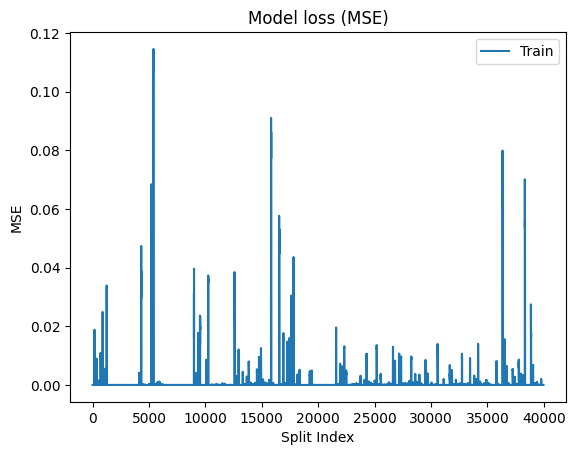

In [96]:
import os
import time
import numpy as np
import pandas as pd
import progressbar  # pip install progressbar2
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define window size and prediction horizon
window_size = 20
prediction_horizon = 3
test_set_size = len(df_train)
interval_id = 0

all_train_loss = []

# Create a PLS regression model
model = PLSRegression(n_components=7)

# Implement rolling-window cross-validation
n_splits = len(df_train) - window_size - prediction_horizon + 1

X_scalers = []
y_centers = []

# TODO taking just a part
for i in progressbar.progressbar(range(n_splits - 250000)):
    # Perform jump if we are at the end of a period! We do not want to predict from 2 months past!
    if i + window_size + prediction_horizon >= interval_lens_cum_sums[interval_id]:
        if i < interval_lens_cum_sums[interval_id]:
            continue
        else:
            interval_id += 1

    # Extract the current window of data
    window_data = df_train.iloc[i:i + window_size + prediction_horizon]

    # Split the window data into features (X) and target (y)
    X_train = window_data.iloc[:window_size].drop(columns=['% Silica Concentrate']).values
    y_train_past = window_data.iloc[:window_size]['% Silica Concentrate'].values
    y_train = window_data.iloc[1:window_size + 1]['% Silica Concentrate'].values - np.mean(y_train_past)
    y_centers.append(np.mean(y_train_past))

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_scalers.append(scaler)

    try:
        model.fit(X_train, y_train)
    except Exception as e:
        ...
        # print(e)
        # print(y_train)
        # print(f"An exception occurred while fitting the model at split {i}.")

    # Predict the target values
    y_train_pred = model.predict(X_train)

    # Calculate the Mean Squared Error (MSE) for this prediction
    mse = mean_squared_error(y_train, y_train_pred)
    all_train_loss.append(mse)

# Plot the training loss (MSE) for each split
plt.plot(all_train_loss, label='Train')
plt.title('Model loss (MSE)')
plt.ylabel('MSE')
plt.xlabel('Split Index')
plt.legend(loc='upper right')
plt.show()

In [94]:
# Predict on validation data
y_true = []  # True target values
y_pred = []  # Predicted target values
mse_scores = []

df_test = df[test_set_size:int(test_set_size + test_set_size*0.2)]
# Iterate over the test data with a sliding window
# TODO taking just a part
for i in progressbar.progressbar(range(len(df_test) - window_size - prediction_horizon + 1 - 50000)):
    # Extract the current window of data
    window_data = df_test.iloc[i:i + window_size + prediction_horizon]

    X_test = window_data.iloc[:window_size].drop(columns=['% Silica Concentrate']).values
    y_test = window_data.iloc[1:window_size + 1]['% Silica Concentrate'].values - y_centers[i]

    # print(X_scalers[i].mean_)
    # print(X_scalers[i].scale_)

    X_test = X_scalers[i].transform(X_test)

    y_test_pred = model.predict(X_test)

    y_true.append(y_test)
    y_pred.append(y_test_pred)
    
    mse = mean_squared_error(y_test, y_test_pred)  
    mse_scores.append(mse)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

100% (7978 of 7978) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


In [90]:
y_true.shape

array([[-0.63 , -0.63 , -0.63 , ..., -0.63 , -0.63 , -0.63 ],
       [-0.63 , -0.63 , -0.63 , ..., -0.63 , -0.63 , -0.63 ],
       [-0.619, -0.619, -0.619, ..., -0.619, -0.619, -0.619],
       ...,
       [ 2.73 ,  2.73 ,  2.73 , ...,  2.73 ,  2.73 ,  2.73 ],
       [ 2.73 ,  2.73 ,  2.73 , ...,  2.73 ,  2.73 ,  2.73 ],
       [ 2.73 ,  2.73 ,  2.73 , ...,  2.73 ,  2.73 ,  2.73 ]])

In [80]:
# Print true value and predicted value for visual comparison
"""
for x in enumerate(y_true):
    i=x[0]
    print(y_true[i],  y_pred[0])
"""

'\nfor x in enumerate(y_true):\n    i=x[0]\n    print(y_true[i],  y_pred[0])\n'

In [95]:
print(f"Average MSE {sum(mse_scores)/len(mse_scores)}")

Average MSE 4.167727741781874


In [ ]:
"""
# Example division of data into training, validation and test sets for the normal functioning times:
# data: data from each minute
# about 70% for training, 15% for validation, 15% for testing

# Reduce the amount of observations (with averaging)
df = df.resample("T").mean()

included_rows1 = [df.index.get_loc(datetime.datetime(2017,4,23,19,0,0)),
                    df.index.get_loc(datetime.datetime(2017,5,13,0,59,00))]
included_rows2 = [df.index.get_loc(datetime.datetime(2017,6,15,1,0,0)),
                    df.index.get_loc(datetime.datetime(2017,7,24,0,59,00))]
included_rows3 = [df.index.get_loc(datetime.datetime(2017,8,15,1,0,0)),
                    df.index.get_loc(datetime.datetime(2017,9,10,0,0,0))]

test_mins = 5
training_n = 5 # training mins = training_n*test_mins
test_start = '2017-04-23 00:00:00' # example start of test partition
test_start = datetime.datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')
flag = 0

df_array = df.to_numpy()
row_number = df.index.get_loc(test_start)

# Iterate through the data
while flag == 0:
    test_y_end = row_number+test_mins+1
    training_X_start = row_number-(training_n+1)*test_mins
    # Stay within included rows
    if ((test_y_end <= included_rows1[1] and training_X_start >= included_rows1[0])
    or (test_y_end <= included_rows2[1] and training_X_start >= included_rows2[0])
    or (test_y_end <= included_rows3[1] and training_X_start >= included_rows3[0])):
        
        scaler = StandardScaler()
        
        # Testing set
        test_X = df_array[row_number:test_y_end-1,:-1]
        test_y = df_array[row_number+1:test_y_end,-1]

        # Validation set
        validation_X = df_array[row_number-test_mins:row_number,:-1]
        validation_y = df_array[row_number-test_mins+1:row_number+1,-1]

        # Training set
        training_X = df_array[training_X_start:row_number-test_mins,:-1]
        training_y = df_array[training_X_start+1:row_number-test_mins+1,-1]
        
        # Lagged predictor variables and the response variable in one matrix
        test_data = np.column_stack([test_X, test_y])
        validation_data = np.column_stack([validation_X, validation_y])
        training_data = np.column_stack([training_X, training_y])
        
        # Compute the mean and std with training data
        scaler.fit(training_data)
        # Perform standardization
        training_data = scaler.transform(training_data)
        validation_data = scaler.transform(validation_data)
        test_data = scaler.transform(test_data)

        if test_y_end == included_rows3[1]:
            flag = 1

        row_number = row_number + 1
    else:
        if test_y_end > included_rows3[1]:
            flag = 1

        row_number = row_number + 1
        
"""

In [ ]:
"""
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f


def get_optimal_n_components(X, y, n_comp):
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)

    print("Suggested number of components: ", msemin + 1)
    opt_n_comp = msemin + 1

    return opt_n_comp


def show_metrices(pls, X, y, show_plots=False):
    y_c = pls.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f' % score_c)
    print('R2 CV: %5.3f' % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    if show_plots:
        # Fit a line to the CV vs response
        z = np.polyfit(y, y_c, 1)
        with plt.style.context(('ggplot')):
            fig, ax = plt.subplots(figsize=(9, 5))
            ax.scatter(y_c, y, c='red', edgecolors='k')

            # Plot the best fit line
            ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)

            # Plot the ideal 1:1 line
            ax.plot(y, y, color='green', linewidth=1)
            plt.title('$R^{2}$ (CV): ' + str(score_cv))
            plt.xlabel('Predicted $^{\circ}$Brix')
            plt.ylabel('Measured $^{\circ}$Brix')

            plt.show()


def get_Q_factors(pls, X, conf=0.95, step=100):
    # Get X scores
    T = pls.x_scores_
    # Get X loadings
    P = pls.x_loadings_
    # Calculate error array
    Err = X - np.dot(T, P.T)
    # Calculate Q-residuals (sum over the rows of the error array)
    Q = np.sum(Err ** 2, axis=1)
    # Estimate the confidence level for the Q-residuals
    i = np.max(Q) + 1
    while 1 - np.sum(Q > i) / np.sum(Q > 0) > conf:
        i -= 100
    Q_conf = i
    return Q, Q_conf


def get_T2s(pls, X, conf=0.95, n_comp=5):
    # Calculate Hotelling's T-squared (note that data are normalised by default)
    Tsq = np.sum((pls.x_scores_ / np.std(pls.x_scores_, axis=0)) ** 2, axis=1)
    # Calculate confidence level for T-squared from the ppf of the F distribution
    Tsq_conf = f.ppf(q=conf, dfn=n_comp,
                     dfd=(X.shape[0] - n_comp)) * n_comp * (X.shape[0] - 1) / (X.shape[0] - n_comp)
    return Tsq, Tsq_conf


def show_Q_T2_plot(Q, Tsq, Q_conf, Tsq_conf):
    plt.scatter(Tsq, Q, c="grey")
    plt.plot([Tsq_conf, Tsq_conf], [plt.axis()[2], plt.axis()[3]], '--')
    plt.plot([plt.axis()[0], plt.axis()[1]], [Q_conf, Q_conf], '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
    plt.show()


print(training_X.shape)
n_comp = get_optimal_n_components(training_X, training_y, 7)
max_outliers = int(training_y.shape[0] * 0.1)
print(f"The maximum number of outliers is: {max_outliers}")

pls = PLSRegression(n_components=n_comp)
pls.fit(training_X, training_y)

show_metrices(pls, training_X, training_y, True)

Q, Q_conf = get_Q_factors(pls, training_X, step=1000)
Tsq, Tsq_conf = get_T2s(pls, training_X)
show_Q_T2_plot(Q, Tsq, Q_conf, Tsq_conf)

# Sort calibration spectra according to descending RMS distance
rms_dist = np.flip(np.argsort(np.sqrt(Q ** 2 + Tsq ** 2)), axis=0)
Xc = training_X[rms_dist, :]
Yc = training_y[rms_dist]

# Discard one outlier at a time up to the value max_outliers
# and calculate the mse cross-validation of the PLS model
mse = np.zeros(max_outliers)  # Define empty mse array
for j in range(1, max_outliers, 10):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(Xc[j:, :], Yc[j:])
    y_cv = cross_val_predict(pls, Xc[j:, :], Yc[j:], cv=10)
    mse[j] = r2_score(Yc[j:], y_cv)

# Find the position of the minimum in the mse (excluding the zeros)
mse_min = np.where(mse == np.max(mse[np.nonzero(mse)]))[0][0]
print(f"The chosen number of outliers is: {mse_min}")

# Fit to the entire dataset
pls_outlier_remove = PLSRegression(n_components=n_comp)
pls_outlier_remove.fit(Xc[mse_min:, :], Yc[mse_min:])
y_c = pls_outlier_remove.predict(Xc[mse_min:, :])
y_cv = cross_val_predict(pls_outlier_remove, Xc[mse_min:, :], Yc[mse_min:], cv=10)

show_metrices(pls_outlier_remove, Xc[mse_min:, :], Yc[mse_min:], show_plots=True)

Q, Q_conf = get_Q_factors(pls_outlier_remove, Xc[mse_min:, :], step=5000)
Tsq, Tsq_conf = get_T2s(pls_outlier_remove, Xc[mse_min:, :])
show_Q_T2_plot(Q, Tsq, Q_conf, Tsq_conf)
"""